# Voting

In [78]:
# Importing the libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

f_size = 11
# Importing the dataset
dataset = pd.read_csv('CVDdataset.csv') #11
# dataset = pd.read_csv('CVD dataset-plin-7-9.csv') #14
# dataset = pd.read_csv('CVD-dataset-plin-0-4-6-7-9.csv') #11
print(dataset)
# dataset = pd.read_csv('CVD dataset2.csv')
# dataset = pd.read_csv('CVD-dataset-2-3-11-13-15.csv')
# dataset = pd.read_csv('CVD dataset-plin-4-7-9.csv') #διαβάζω το dataset που δεν περιλαμβανει τα features 7 και 9
# dataset = pd.read_csv('CVD-dataset-1-2-3-5-10-11-12-13-14-15.csv')
data=dataset.iloc[:, :].values
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, f_size].values
# X = dataset.iloc[:, [ 0, 1, 2, 5, 10, 11, 13, 15]].values

rows = len(data)    # 3 rows in your example
cols = len(data[0])
print(rows)
print(cols)

      Age    DD    BMI  Smoking  ypolip  PulsBP  aca0   gla0   chl0    tg0  \
0    71.0  18.0  19.78      1.0     1.0      55   6.6   90.0  153.0   71.0   
1    38.0   2.0  23.31      3.0     1.0      20  10.0  260.0  189.0   79.0   
2    81.0   7.0  29.06      2.0     1.0      65   5.4  140.0  161.0   90.0   
3    50.0  11.0  27.93      3.0     1.0      40   7.1  160.0  204.0   78.0   
4    62.0  25.0  20.70      1.0     1.0      45   4.2  100.0  153.0   51.0   
..    ...   ...    ...      ...     ...     ...   ...    ...    ...    ...   
555  58.0   3.0  24.96      2.0     1.0      60   5.8  140.0  210.0  138.0   
556  77.0  17.0  25.10      1.0     1.0      70   6.9  145.0  202.0   72.0   
557  66.0   0.0  29.21      1.0     2.0      60   6.4  130.0  330.0  282.0   
558  71.0  22.0  31.57      1.0     1.0      80   9.5  145.0  216.0  235.0   
559  56.0   0.0  32.28      1.0     2.0      60   7.1  125.0  156.0   85.0   

     hdl0  CVD prediction  
0    50.0             0.0  
1    47

Text(0.5, 0.98, 'Age')

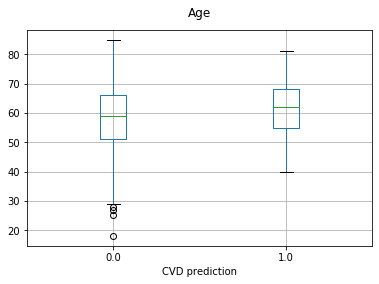

In [150]:
dataset.boxplot(column = 'Age', by = 'CVD prediction');
plt.title('')
plt.suptitle('Age')
# dataset.boxplot(grid=False, rot=60, fontsize=15,figsize=(20,10));

In [ ]:
dataNoCvd = data[~(data[:,f_size] > 0.0)]
dataCvd = data[~(data[:,f_size] < 1.0)]
rowsNoCvd = len(dataNoCvd)    
rowsCvd = len(dataCvd)
print(rowsNoCvd)
print(rowsCvd)
# print(dataNoCvd)
# print(dataCvd)

In [ ]:
def find_NoCvd_limitsArray(i,DownNoCvd, UpNoCvd, fold_NoCvd_total, fold_NoCvd_residue):
    if i>0 :
        DownNoCvd = UpNoCvd
        UpNoCvd= fold_NoCvd_total+UpNoCvd
    if i < fold_NoCvd_residue :
        UpNoCvd+= 1
#     print("NoCvd limits, Down :",DownNoCvd,"Up ",UpNoCvd)
    return   DownNoCvd, UpNoCvd   
 
def find_Cvd_limitsArray(i,DownCvd, UpCvd, fold_Cvd_total, fold_Cvd_residue,cv):
    if i>0 :
        DownCvd = UpCvd
        UpCvd= fold_Cvd_total+UpCvd
    if i >= cv - fold_Cvd_residue :
         UpCvd+= 1     
#     print("Cvd limits, Down :",DownCvd,"Up ",UpCvd)
    return   DownCvd, UpCvd  

def find_testValSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd):
    temp1=dataNoCvd[DownNoCvd:UpNoCvd,:]
    temp2=dataCvd[DownCvd:UpCvd,:]
    temp3=np.concatenate((temp1, temp2))
#     print(len(temp1),"  ",len(temp2),"  ",len(temp3))
    return temp3

def find_trainSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd):
    temp1 = np.delete(dataNoCvd, slice(DownNoCvd, UpNoCvd), axis=0)
    temp2 = np.delete(dataCvd, slice(DownCvd, UpCvd), axis=0)
    temp3 = np.concatenate((temp1, temp2))
#     print(len(temp1),"  ",len(temp2),"  ",len(temp3))
    return temp1, temp2, temp3

def find_trainSubset1(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd):
    temp1 = np.delete(dataNoCvd, slice(DownNoCvd, UpNoCvd), axis=0)
    temp2 = np.delete(dataCvd, slice(DownCvd, UpCvd), axis=0)
#     print("len 1-2:",len(temp1),len(temp2))
    temp3 = np.delete(temp1, slice(0, 46), axis=0)
    temp4 = np.delete(temp2, slice(0, 4), axis=0)
#     print("len 3-4:",len(temp3),len(temp4))
    temp5 = np.concatenate((temp3, temp4))
#     print(len(temp5))
    return temp3, temp4, temp5

In [4]:
def create_train_test_sets(f_size,cv,dataNoCvd,dataCvd,val_ratio):
    test_total = []
    train_total = []
    train_total_Cvd = []
    train_total_NoCvd = []
    validation_total = []
    
    rowsNoCvd = len(dataNoCvd)    
    rowsCvd = len(dataCvd)

    fold_Cvd_total = rowsCvd//cv
    fold_Cvd_residue= rowsCvd%cv
    print("fold_Cvd_total  :",fold_Cvd_total," fold_Cvd_residue  :",fold_Cvd_residue)

    fold_NoCvd_total = rowsNoCvd//cv
    fold_NoCvd_residue= rowsNoCvd%cv
    print("fold_NoCvd_total:",fold_NoCvd_total,"fold_NoCvd_residue:",fold_NoCvd_residue)
    
    Cvd_val = round(504*val_ratio*(rowsCvd/len(data)))
    noCvd_val = round(504*val_ratio)-Cvd_val
#     print(noCvd_val)
    
    DownNoCvd=0
    DownCvd=0
    UpNoCvd = fold_NoCvd_total
    UpCvd = fold_Cvd_total

    for i in range(cv):
        X_test = []
        y_test = []
        X_train = []
        y_train = []
        X_val = []
        y_val = []
#         print("============",i,"==============")
        DownNoCvd, UpNoCvd = find_NoCvd_limitsArray(i, DownNoCvd, UpNoCvd, fold_NoCvd_total, fold_NoCvd_residue)
        DownCvd, UpCvd = find_Cvd_limitsArray(i, DownCvd, UpCvd, fold_Cvd_total, fold_Cvd_residue,cv)
#         print(DownNoCvd,UpNoCvd,DownCvd,UpCvd)
        testSubset_total = find_testValSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd)        
        
        if i!=9:
        #όταν δεν είμαστε στο 10ο fold(ξεκινάμε από 0) παίρνουμε τα επόμενα 56 και 4 instaces για το validation set
            validationSubset_total = find_testValSubset(UpNoCvd,UpNoCvd+noCvd_val,UpCvd,UpCvd+Cvd_val,dataNoCvd,dataCvd)
            trainSubset_NoCvd ,trainSubset_Cvd ,trainSubset_total = find_trainSubset(DownNoCvd,UpNoCvd+noCvd_val,DownCvd,UpCvd+Cvd_val,dataNoCvd,dataCvd)
        else:
        #όταν είμαστε στο 10ο fold παίρνουμε τα προηγούμενα 56 και 4 instaces για το validation set
#         DownNoCvd-noCvd_val,DownNoCvd,DownCvd-Cvd_val,DownCvd
            validationSubset_total = find_testValSubset(0,noCvd_val,0,Cvd_val,dataNoCvd,dataCvd)
            print(DownNoCvd,UpNoCvd,DownCvd,UpCvd)
            trainSubset_NoCvd ,trainSubset_Cvd ,trainSubset_total = find_trainSubset1(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd)
    
    #creating X_train, y_train, X_test, y_test
        X_test.append(np.delete(testSubset_total, f_size, axis=1))
        y_test_temp = np.delete(testSubset_total, slice(0, f_size), axis=1)
        y_test.append(np.reshape(y_test_temp, len(y_test_temp)))
        X_test_temp = np.array(X_test)
        X_test = X_test_temp[0]
        y_test_temp = np.array(y_test)
        y_test = y_test_temp[0]
        
        X_val.append(np.delete(validationSubset_total, f_size, axis=1))
        y_val_temp = np.delete(validationSubset_total, slice(0, f_size), axis=1)
        y_val.append(np.reshape(y_val_temp, len(y_val_temp)))
        X_val_temp = np.array(X_val)
        X_val = X_val_temp[0]
        y_val_temp = np.array(y_val)
        y_val = y_val_temp[0]
        
        X_train.append(np.delete(trainSubset_total, f_size, axis=1))
        y_train_temp = np.delete(trainSubset_total, slice(0, f_size), axis=1)
        y_train.append(np.reshape(y_train_temp, len(y_train_temp)))
        X_train_temp = np.array(X_train)
        X_train = X_train_temp[0]
        y_train_temp = np.array(y_train)
        y_train = y_train_temp[0]
        
    #add every subset in a list so we can handle thm later 
        test_total.append([X_test,y_test])
        validation_total.append([X_val,y_val])
        train_total.append([X_train,y_train]) 
        train_total_NoCvd.append(trainSubset_NoCvd)
        train_total_Cvd.append(trainSubset_Cvd)
    return train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd

In [5]:
train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd = create_train_test_sets(f_size,10,dataNoCvd,dataCvd,0.1)

fold_Cvd_total  : 4  fold_Cvd_residue  : 1
fold_NoCvd_total: 51 fold_NoCvd_residue: 9
468 519 36 41


In [6]:
# Chech ratio in each train and test set
def find_ratio(index_list):
    one = 0
    lenght=len(index_list[0])
    for i in range(lenght):
#         print(index_list[1])
        if index_list[1][i] == 1.0 :
            one+= 1
    ratio = one/lenght
    return ratio

for i in range(10):
    print(len(train_total[i][0]))
    ratio = find_ratio(train_total[i])
    print("ratio in train set:", ratio)
    ratio = find_ratio(test_total[i])
    print("ratio in test set:", ratio)
    ratio = find_ratio(validation_total[i])
    print("ratio in validation set:", ratio)

454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in vali

In [159]:
import matplotlib.pyplot as plt
import shap
from matplotlib import pyplot
from xgboost import plot_importance
import math

def predict_weighted_average(models,X,weights):
#     print("efwef",len(weights), len(models))
    y_pred = []
    y_pred_prob = []
    y_pred_models = []
    y_pred_models1 = []
#     weights = [0.16, 0.175, 0.2, 0.147, 0.148, 0.16]
#     weights = [0.15, 0.4, 0.2, 0.05, 0.05, 0.15]
#   weights = [0.16, 0.173, 0.2, 0.147, 0.16, 0.16]
    models_size = len(models)
#     print(models_size)
    X_size = len(X)
            
    for i in range(models_size):
        y_pred_models.append(models[i].predict(X,output_margin=True))  
        y_pred_models1.append(models[i].predict_proba(X)[:,1])
        
        
    total_shap_values = []
    total_expected_value = 0
    for i in range(models_size):
        explainer = shap.TreeExplainer(models[i])
#         explainer = shap.TreeExplainer(models[i],feature_perturbation="interventional",model_output="probability")
        # calculate shap values. This is what we will plot.
        # Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
         
        pp =models[i].get_booster().get_score(importance_type="cover")
        print(pp)
        p = fill_importances(pp)
        print(p)
        print("==========",weights,"=============")
        for key in p:
            p[key] = p[key]*weights[i]*0.1
            
        if(i==0):
             importances = p.copy()
        else:
            for key in importances:
                importances[key] += p[key]
   
            
        shap_values = explainer.shap_values(X)
        shap_values_auc = [[l*weights[i] for l in k] for k in shap_values]
        
        if(i==0):
             total_shap_values = shap_values_auc.copy()
        else:
            for a in range(len(total_shap_values)):
                for b in range(len(total_shap_values[0])):
                     total_shap_values[a][b] += shap_values_auc[a][b]
        total_expected_value += explainer.expected_value*weights[i] 
#         print("explainer.expected_value",explainer.expected_value)
  
    feature_names = ['Age','DD','BMI','Smoking','ypolip','PulsBP','aca0','gla0','chl0','tg0','hdl0']
    
    
 
    t_shap_values = numpy.array(total_shap_values)
    
#     shap.summary_plot(t_shap_values, X,feature_names)  
    

    shap.force_plot(total_expected_value, t_shap_values[1,:], X[1],feature_names,matplotlib=True,link='logit')

#             ,link='logit'
            
            
        
    for j in range(X_size):
        sum = 0
        sum1 = 0
        for i in range(models_size):
            sum = sum + y_pred_models[i][j]*weights[i]
            sum1 = sum1 + y_pred_models1[i][j]*weights[i]
        avr = sum
#         /models_size
        pred_prob = math.exp(avr)/(1 + math.exp(avr))
        y_pred_prob.append(pred_prob)
        
        if avr>= 0 :
            y_pred.append(1.)
            if(j==1):
                print("prediction YES")
                print(avr)
                print(pred_prob)
#                 print(sum1)
        else:
            y_pred.append(0.)
            if(j==1):
                print("prediction NO")
                print(avr)
                print(pred_prob)
#                 print(sum1)
    return y_pred,t_shap_values,importances,y_pred_prob

In [160]:
def fill_importances(p):
        if p.get("f0")== None:
            p['f0'] = 0
        if p.get("f1")== None:
            p['f1'] = 0
        if p.get("f2")== None:
            p['f2'] = 0
        if p.get("f3")== None:
            p['f3'] = 0
        if p.get("f4")== None:
            p['f4'] = 0
        if p.get("f5")== None:
            p['f5'] = 0
        if p.get("f6")== None:
            p['f6'] = 0
        if p.get("f7")== None:
            p['f7'] = 0
        if p.get("f8")== None:
            p['f8'] = 0
        if p.get("f9")== None:
            p['f9'] = 0
        if p.get("f10")== None:
            p['f10'] = 0
        return p

In [169]:
from xgboost import XGBClassifier


def my_fit(ratio,dataNoCvd,dataCvd, validation_total, params):   
    Subarray=[]
    models = []
    # yarray
    
    rowsNoCvd = len(dataNoCvd)    
    rowsCvd = len(dataCvd)
    print("Size of NoCvd cases in train set:",rowsNoCvd)
    print("Size of Cvd cases in train set  :",rowsCvd)
    print("validation_total",len(validation_total[0][0]))


    numOfSubsamples = rowsNoCvd//(rowsCvd*ratio)
    numOfSubsamples= int(numOfSubsamples)
    SubNoCvd = rowsNoCvd//numOfSubsamples
    residue = rowsNoCvd- SubNoCvd*numOfSubsamples


    Up = 0
    valid_preds = []
    sum_auc = 0
    
    for i in range(numOfSubsamples):
        
        classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=params[5],
                  colsample_bynode=1, colsample_bytree=params[8], gamma=params[4],
                  learning_rate=params[0], max_delta_step=0, max_depth=params[1],
                  min_child_weight=params[3], missing=None, n_estimators=params[2], n_jobs=1,
                  nthread=None, objective='binary:logistic', random_state=0,
                  reg_alpha=params[9], reg_lambda=params[6], scale_pos_weight=params[7], seed=None,
                  silent=None, subsample=params[10], verbosity=1)
    #     print(i)
    #Creating the training set for each model
        Down = Up
        Up= Up + SubNoCvd
        if i < residue :
            Up+= 1
        
#         print(Down)
#         print(Up)
        
        Sub1=dataNoCvd[Down:Up,:]
        Sub2=np.concatenate((Sub1, dataCvd))
        Subarray.append(Sub2)
        
    #Dividing to X and y of the previous traing set    
        X=np.delete(Subarray[i], f_size, axis=1)
        y=np.delete(Subarray[i], slice(0, f_size), axis=1)
        y=np.reshape(y, len(y))
        
        X_val = validation_total[i][0]
        y_val = validation_total[i][1]
        print(len(X),len(X_val))
        eval_set  = [(X,y), (X_val,y_val)]
        
        classifier.fit( X, y, eval_set=eval_set, eval_metric="auc", early_stopping_rounds=50,verbose = False)
#         classifier.fit( X, y)

        #υπολογίζουμε το auc που έχει το μοντέλο για το validation set γιατί θα μας χρειαστεί στο weighted voting
        auc_valid = roc_auc_score(y_val, classifier.predict(X_val))
        print("auc_valid",auc_valid,classifier.best_score, classifier.best_ntree_limit)
        
        #αποθηκεύουμε τα auc σε πίνακα για να τα επιστέψουμε όλα μαζί
        valid_preds.append(auc_valid)
        sum_auc += auc_valid
        
        models.append(classifier)
        
    auc_weights = []
    for i in range(numOfSubsamples):
        auc_weights.append(valid_preds[i]/sum_auc)
        print(auc_weights)
        
    return models, auc_weights 

In [170]:
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

from sklearn.metrics import  confusion_matrix,roc_curve, roc_auc_score, accuracy_score
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import StratifiedKFold # import KFold
from sklearn import metrics
from sklearn.metrics import brier_score_loss

def my_cross_val( cv, train_total, test_total, train_total_NoCvd, train_total_Cvd,params, weights):
    accuracy = []
    specificity = []
    sensitivity = []
    auc = []
    brier_score = []
    cv_total_shap_values = []
    X_shap_total = []
    # print(X)
    for i in range(cv):
#         X_train = train_total[i][0]
#         y_train = train_total[i][1]
        X_test = test_total[i][0]
        y_test = test_total[i][1]
        


        models, auc_weights = my_fit( 2, train_total_NoCvd[i], train_total_Cvd[i], validation_total,params)
    
        
        
        
        y_pred,shap_values,importances,y_pred_prob = predict_weighted_average(models,X_test,auc_weights)
        
        print(len(shap_values[0]))
        print(len(shap_values))
        
        
        if(i==0):
             cv_total_importances = importances.copy()
        else:
            for key in cv_total_importances:
                cv_total_importances[key] += importances[key]

        
        
        if(i==0):
            X_shap_total = X_test.copy()
            cv_total_shap_values = shap_values.copy()          
        else:
            
            X_shap_total = np.concatenate((X_shap_total, X_test), axis=0)
#             print("lala",len(cv_total_shap_values))
#             print(cv_total_shap_values)
#             print(shap_values)
#             print(cv_total_shap_values)
            cv_total_shap_values = np.concatenate((cv_total_shap_values, shap_values), axis=0)
            
                        
       
                        
        cm = confusion_matrix(y_test, y_pred)
    #     print(cm)

        total1=sum(sum(cm))
        #####from confusion matrix calculate accuracy
        accuracy1=(cm[0,0]+cm[1,1])/total1
    #   print ('Accuracy : ', accuracy1)

        specificity1 = cm[0,0]/(cm[0,0]+cm[0,1])
    #   print('Specificity : ', specificity1 )

        sensitivity1 = cm[1,1]/(cm[1,0]+cm[1,1])
    #   print('Sensitivity : ', sensitivity1)
        brier_score_loss1 = brier_score_loss(y_test, y_pred_prob)
#         y = np.array(y_test)
#         pred = np.array(y_pred)
#         fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
#         auc1 = metrics.auc(fpr, tpr)
        
        auc1 = roc_auc_score(y_test, y_pred)

    
        accuracy.append(accuracy1)
        specificity.append(specificity1)
        sensitivity.append(sensitivity1) 
        auc.append(auc1)
        brier_score.append(brier_score_loss1)
     
    feature_names = ['Age','DD','BMI','Smoking','ypolip','PulsBP','aca0','gla0','chl0','tg0','hdl0']
    
#     print("total shap",len(cv_total_shap_values[0]))
#     print("total shap",len(cv_total_shap_values))
#     print("total shap",len(X_shap_total[0]))
#     print("total shap",len(X_shap_total))
    
    cv_total_importances['Age'] = cv_total_importances.pop('f0')
    cv_total_importances['DD'] = cv_total_importances.pop('f1')
    cv_total_importances['BMI'] = cv_total_importances.pop('f2')
    cv_total_importances['Smoking'] = cv_total_importances.pop('f3')
    cv_total_importances['ypolip'] = cv_total_importances.pop('f4')
    cv_total_importances['PulsBP'] = cv_total_importances.pop('f5')
    cv_total_importances['aca0'] = cv_total_importances.pop('f6')
    cv_total_importances['gla0'] = cv_total_importances.pop('f7')
    cv_total_importances['chl0'] = cv_total_importances.pop('f8')
    cv_total_importances['tg0'] = cv_total_importances.pop('f9')
    cv_total_importances['hdl0'] = cv_total_importances.pop('f10')
    
    plot_importance(cv_total_importances,importance_type='cover',max_num_features=None)
    
#     shap.summary_plot(cv_total_shap_values, X_shap_total,feature_names)
    
    return accuracy, specificity, sensitivity, auc, brier_score

In [171]:
a=np.array([[1,1],[2,2]])
b=np.array([[3,3],[4,4]])

for i in range(10):
    a = [[i,i]]
    b = np.concatenate((b, a), axis=0)
#     b += a
print((b))

[[3 3]
 [4 4]
 [0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]
 [8 8]
 [9 9]]


In [172]:
# https://www.geeksforgeeks.org/python-all-possible-permutations-of-n-lists/

def compute_comb(params):
    
    # initializing lists 
    list1 = params.get("learning_rate")
    list2 = params.get("max_depth")
    list3 = params.get("n_estimators") 
    list4 = params.get("min_child_weight")
    list5 = params.get("gamma")    
    list6 = params.get("colsample_bylevel")
    list7 = params.get("reg_lambda") 
    list8 = params.get("scale_pos_weight")
    list9 = params.get("colsample_bytree")
    list10 = params.get("reg_alpha")
    list11 = params.get("subsample")
    

#     # printing lists  
#     print ("The original lists are : " + str(list1) +
#                                    " " + str(list2) + 
#                                    " " + str(list3) + 
#                                    " " + str(list4) + 
#                                    " " + str(list5) + 
#                                    " " + str(list6) +
#                                    " " + str(list7) +
#                                    " " + str(list8)) 

    # using list comprehension  
    # to compute all possible permutations 
    res = [[i, j, k, l, m, n, o, p,q,r,s] for i in list1  
                                          for j in list2 
                                          for k in list3 
                                          for l in list4 
                                          for m in list5 
                                          for n in list6 
                                          for o in list7
                                          for p in list8
                                          for q in list9
                                          for r in list10
                                          for s in list11] 

    # printing result 
#     print ("All possible permutations are : " +  str(res))
    return res

In [173]:
class style:
    BOLD = '\033[1m'
    END = '\033[0m'

In [174]:
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

from sklearn.metrics import  confusion_matrix,roc_curve, roc_auc_score, accuracy_score
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import StratifiedKFold # import KFold
from statistics import mean

def gridsearch(params,weights):
    max_sens = 0
    max_spes = 0
    max_acc = 0
    best_params = []
    max_params = []
    max_auc = 0
    combs = compute_comb(params)
#     print(len(combs))
    for j in range(len(combs)):
#         print(j)
        accuracy, specificity, sensitivity, auc, brier_score = my_cross_val( 10, train_total, test_total, train_total_NoCvd, train_total_Cvd,combs[j],weights)
        if mean(auc)>0.69:
            print(style.BOLD + "----------------------------------------------------------------"+ style.END)
            print(combs[j])
            print (style.BOLD + 'accuracy    ' + style.END, mean(accuracy))
            print (style.BOLD + 'specificity ' + style.END, mean(specificity))
            print (style.BOLD + 'sensitivity ' + style.END, mean(sensitivity))
            print (style.BOLD + 'auc         ' + style.END, mean(auc))
            print (style.BOLD + 'brier_score ' + style.END, mean(brier_score))
            print (style.BOLD + 'weights     ' + style.END, weights)
            print(style.BOLD + "----------------------------------------------------------------"+ style.END)
#         else:
#             print(combs[j])
#             print("accuracy    ",mean(accuracy))
#             print("specificity ",mean(specificity))
#             print("sensitivity ",mean(sensitivity))
#             print("auc         ",mean(auc))
#             print("weights     ",weights)
            
        best_params.append([combs[j],mean(accuracy),mean(specificity),mean(sensitivity),mean(auc), mean(brier_score), weights])
        if mean(auc)> max_auc:
            max_sens = mean(sensitivity)
            max_spes = mean(specificity)
            max_acc = mean(accuracy)
            max_auc = mean(auc)
            max_params = combs[j]
    return max_sens, max_params, max_spes, max_acc, max_auc, best_params

# Ratio = 2

 Αποτέλεσμα της gridsearch με τις ακόλουθες παραμέτρους, γίνονται print όλα και αυτά που ικανοποιούν την συνθήκη : if mean(sensitivity)> 0.5 and mean(specificity)>0.6 and mean(accuracy)>0.6 and mean(auc)>0.5 είναι με bold και μεταξύ γραμμών.

In [175]:
#σωστό
params = {
                    "learning_rate"    :[0.5],  #0.01-0.2 Makes the model more robust by shrinking the weights on each step
                    "max_depth"        :[2],  #3-10 control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
                    "n_estimators"     :[1000],
                    "min_child_weight" :[3],         #0.5-1 small values might lead to under-fitting
                    "gamma"            :[0.5],            #Makes the algorithm conservative --> No overfitting
                    "colsample_bylevel" :[0.5], #0.5-1
                     "reg_lambda"      :[1], #  it should be explored to reduce overfitting.
                    "scale_pos_weight" :[3],
                    "colsample_bytree" :[0.75],
                    "reg_alpha"        :[0],
                    "subsample"        :[1.0]
    
        }
# [0.5, 2, 1000, 3, 0.5, 0.6, 1, 3, 0.8, 0, 1.0]
# accuracy     0.6875
# specificity  0.6802790346907994
# sensitivity  0.785
# auc          0.7326395173453997
# weights      [0.2, 0.05, 0.33, 0.13, 0.15, 0.14]

Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
auc_valid 0.7010869565217391 0.663043 24
103 50
auc_valid 0.8804347826086957 0.961957 91
103 50
auc_valid 0.8152173913043479 0.967391 52
103 50
auc_valid 0.7282608695652174 0.853261 42
103 50
auc_valid 0.782608695652174 0.940217 105
103 50
auc_valid 0.7717391304347826 0.858696 73
[0.14982578397212545]
[0.14982578397212545, 0.18815331010452963]
[0.14982578397212545, 0.18815331010452963, 0.1742160278745645]
[0.14982578397212545, 0.18815331010452963, 0.1742160278745645, 0.1556329849012776]
[0.14982578397212545, 0.18815331010452963, 0.1742160278745645, 0.1556329849012776, 0.1672473867595819]
[0.14982578397212545, 0.18815331010452963, 0.1742160278745645, 0.1556329849012776, 0.1672473867595819, 0.16492450638792103]


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f5': 22.92344584285714, 'f7': 16.63588946875, 'f4': 31.851102825, 'f2': 19.44966466368421, 'f9': 16.178840132105258, 'f10': 17.874921194545458, 'f3': 16.51021921, 'f8': 20.623494524999998, 'f6': 15.50922685875, 'f0': 13.364563853000002, 'f1': 17.300115487}
{'f5': 22.92344584285714, 'f7': 16.63588946875, 'f4': 31.851102825, 'f2': 19.44966466368421, 'f9': 16.178840132105258, 'f10': 17.874921194545458, 'f3': 16.51021921, 'f8': 20.623494524999998, 'f6': 15.50922685875, 'f0': 13.364563853000002, 'f1': 17.300115487}
========== [0.14982578397212545, 0.18815331010452963, 0.1742160278745645, 0.1556329849012776, 0.1672473867595819, 0.16492450638792103] =============
{'f7': 20.70075003625, 'f4': 22.304866927142857, 'f3': 19.601674627142863, 'f8': 18.515532801052633, 'f1': 16.603079240833335, 'f10': 20.050001624, 'f6': 17.245077132499997, 'f0': 16.388398245882353, 'f2': 19.303862205, 'f9': 16.86046426814815, 'f5': 13.600256178571428}
{'f7': 20.70075003625, 'f4': 22.304866927142857, 'f3': 19.6016

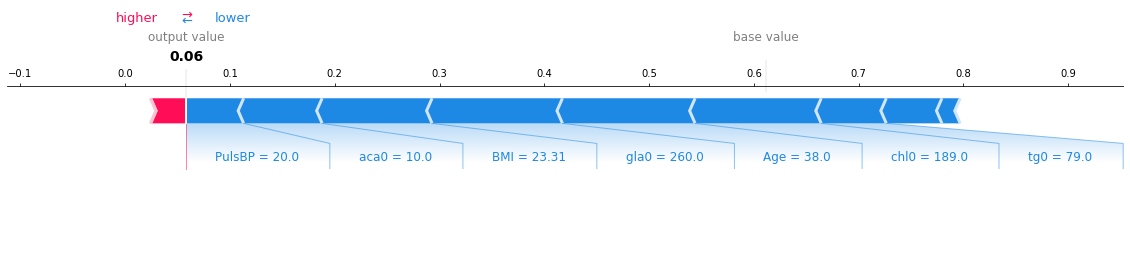

prediction NO
-2.785942183969744
0.05808857810339477
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
auc_valid 0.47282608695652173 0.483696 16
103 50
auc_valid 0.5923913043478262 0.690217 2
103 50
auc_valid 0.8260869565217391 1.0 44
103 50
auc_valid 0.7391304347826086 0.891304 39
103 50
auc_valid 0.8260869565217391 0.923913 97
103 50
auc_valid 0.7608695652173914 0.891304 8
[0.11211340206185566]
[0.11211340206185566, 0.14046391752577322]
[0.11211340206185566, 0.14046391752577322, 0.1958762886597938]
[0.11211340206185566, 0.14046391752577322, 0.1958762886597938, 0.17525773195876287]
[0.11211340206185566, 0.14046391752577322, 0.1958762886597938, 0.17525773195876287, 0.1958762886597938]
[0.11211340206185566, 0.14046391752577322, 0.1958762886597938, 0.17525773195876287, 0.1958762886597938, 0.18041237113402062]
{'f5': 31.704991033333332, 'f7': 14.307706955, 'f2': 21.519869233125, 'f1': 20.385655110000002, 'f6': 19.361277191249997, '

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f2': 19.61435168409091, 'f5': 17.17483734, 'f3': 20.288545612500002, 'f9': 19.094446716874998, 'f8': 19.420737603529414, 'f0': 15.552215704761906, 'f6': 23.40692158, 'f7': 13.415775172500002, 'f1': 20.72751216833333, 'f10': 15.640596612307693, 'f4': 13.8388176}
{'f2': 19.61435168409091, 'f5': 17.17483734, 'f3': 20.288545612500002, 'f9': 19.094446716874998, 'f8': 19.420737603529414, 'f0': 15.552215704761906, 'f6': 23.40692158, 'f7': 13.415775172500002, 'f1': 20.72751216833333, 'f10': 15.640596612307693, 'f4': 13.8388176}
========== [0.11211340206185566, 0.14046391752577322, 0.1958762886597938, 0.17525773195876287, 0.1958762886597938, 0.18041237113402062] =============
{'f2': 18.385333359375, 'f9': 16.231113294375003, 'f6': 19.40999188833333, 'f10': 17.512119713928566, 'f1': 20.06340939142857, 'f3': 18.737136147142856, 'f0': 17.656413798333336, 'f5': 12.37210483857143, 'f7': 17.43059937111111, 'f8': 17.688532137058825, 'f4': 15.57902984}
{'f2': 18.385333359375, 'f9': 16.231113294375003

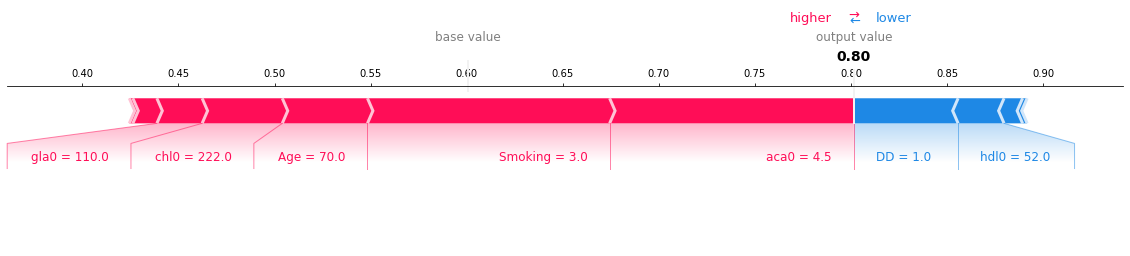

prediction YES
1.3957400741343646
0.8015070323787531
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
auc_valid 0.9021739130434783 0.940217 70
103 50
auc_valid 0.5434782608695652 0.55163 4
103 50
auc_valid 0.5597826086956521 0.581522 1
103 50
auc_valid 0.6956521739130435 0.907609 24
103 50
auc_valid 0.8043478260869565 0.923913 59
103 50
auc_valid 0.6956521739130435 0.855978 4
[0.21474773609314363]
[0.21474773609314363, 0.12936610608020702]
[0.21474773609314363, 0.12936610608020702, 0.1332470892626132]
[0.21474773609314363, 0.12936610608020702, 0.1332470892626132, 0.16558861578266496]
[0.21474773609314363, 0.12936610608020702, 0.1332470892626132, 0.16558861578266496, 0.1914618369987064]
[0.21474773609314363, 0.12936610608020702, 0.1332470892626132, 0.16558861578266496, 0.1914618369987064, 0.16558861578266496]


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f5': 18.48180831857143, 'f4': 28.78989108, 'f1': 20.271927422222223, 'f8': 17.721652805625, 'f10': 19.040309356000005, 'f2': 18.015543547, 'f6': 18.50746654318182, 'f0': 14.300850066153847, 'f7': 13.79540162375, 'f9': 18.164353800769227, 'f3': 12.196600586666667}
{'f5': 18.48180831857143, 'f4': 28.78989108, 'f1': 20.271927422222223, 'f8': 17.721652805625, 'f10': 19.040309356000005, 'f2': 18.015543547, 'f6': 18.50746654318182, 'f0': 14.300850066153847, 'f7': 13.79540162375, 'f9': 18.164353800769227, 'f3': 12.196600586666667}
========== [0.21474773609314363, 0.12936610608020702, 0.1332470892626132, 0.16558861578266496, 0.1914618369987064, 0.16558861578266496] =============
{'f7': 22.47799171818182, 'f5': 22.00904162, 'f2': 17.053508348571427, 'f1': 18.142437121428568, 'f8': 20.30374516740741, 'f10': 23.080285007333334, 'f0': 24.04067728, 'f4': 23.654221833333335, 'f9': 15.760288544285713, 'f6': 19.96074144, 'f3': 17.671429333333332}
{'f7': 22.47799171818182, 'f5': 22.00904162, 'f2': 17

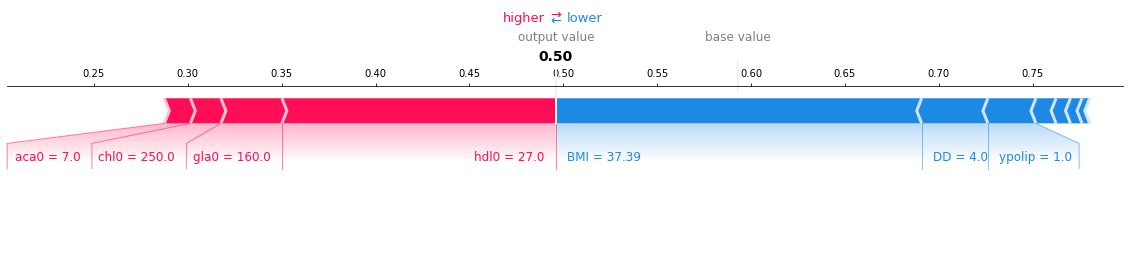

prediction NO
-0.01580989461049992
0.49604760867296127
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
auc_valid 0.8804347826086957 0.918478 81
103 50
auc_valid 0.9565217391304348 1.0 18
103 50
auc_valid 0.5869565217391305 0.711957 37
103 50
auc_valid 0.625 0.663043 40
103 50
auc_valid 0.8260869565217391 0.961957 50
103 50
auc_valid 0.7608695652173914 0.853261 17
[0.1899179366940211]
[0.1899179366940211, 0.2063305978898007]
[0.1899179366940211, 0.2063305978898007, 0.12661195779601409]
[0.1899179366940211, 0.2063305978898007, 0.12661195779601409, 0.13481828839390386]
[0.1899179366940211, 0.2063305978898007, 0.12661195779601409, 0.13481828839390386, 0.17819460726846423]
[0.1899179366940211, 0.2063305978898007, 0.12661195779601409, 0.13481828839390386, 0.17819460726846423, 0.16412661195779601]
{'f5': 20.886471201428574, 'f4': 29.930375075, 'f9': 19.83359493125, 'f6': 18.607474685454548, 'f10': 18.493734353636366, 'f1': 19.8214993

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f2': 18.506224682499997, 'f5': 23.414611957142856, 'f9': 18.515215245882352, 'f3': 21.393115020000003, 'f6': 19.40845213277778, 'f4': 26.439445499999998, 'f7': 20.683577310909094, 'f8': 19.805698396, 'f10': 18.398229249999996, 'f1': 17.67416065071428, 'f0': 16.138972808888887}
{'f2': 18.506224682499997, 'f5': 23.414611957142856, 'f9': 18.515215245882352, 'f3': 21.393115020000003, 'f6': 19.40845213277778, 'f4': 26.439445499999998, 'f7': 20.683577310909094, 'f8': 19.805698396, 'f10': 18.398229249999996, 'f1': 17.67416065071428, 'f0': 16.138972808888887}
========== [0.1899179366940211, 0.2063305978898007, 0.12661195779601409, 0.13481828839390386, 0.17819460726846423, 0.16412661195779601] =============
{'f2': 19.681642252083336, 'f5': 20.383622568333337, 'f6': 18.365564189, 'f0': 17.859008915333334, 'f9': 17.94830024375, 'f7': 14.930361172222222, 'f10': 17.699756891666667, 'f3': 15.0694160425, 'f8': 18.539133893, 'f1': 14.256717334999998, 'f4': 14.3920097}
{'f2': 19.681642252083336, 'f5'

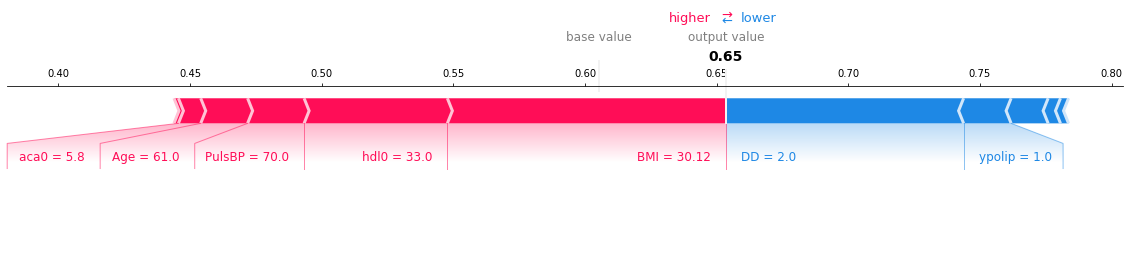

prediction YES
0.6348234100610124
0.6535823498211192
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
auc_valid 0.891304347826087 0.929348 37
103 50
auc_valid 0.9673913043478262 1.0 16
103 50
auc_valid 0.9891304347826088 1.0 26
103 50
auc_valid 0.5163043478260869 0.622283 7
103 50
auc_valid 0.625 0.586957 1
103 50
auc_valid 0.7934782608695652 0.858696 3
[0.18636363636363637]
[0.18636363636363637, 0.2022727272727273]
[0.18636363636363637, 0.2022727272727273, 0.20681818181818185]
[0.18636363636363637, 0.2022727272727273, 0.20681818181818185, 0.10795454545454544]
[0.18636363636363637, 0.2022727272727273, 0.20681818181818185, 0.10795454545454544, 0.13068181818181818]
[0.18636363636363637, 0.2022727272727273, 0.20681818181818185, 0.10795454545454544, 0.13068181818181818, 0.1659090909090909]


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f0': 19.72017447, 'f4': 29.887648125, 'f9': 23.123628881818185, 'f6': 19.415100724210525, 'f1': 16.07299947222222, 'f10': 18.397253199565213, 'f8': 16.27328889411765, 'f3': 9.423888526666667, 'f7': 12.63903491, 'f2': 17.902657036666664, 'f5': 11.194646516666666}
{'f0': 19.72017447, 'f4': 29.887648125, 'f9': 23.123628881818185, 'f6': 19.415100724210525, 'f1': 16.07299947222222, 'f10': 18.397253199565213, 'f8': 16.27328889411765, 'f3': 9.423888526666667, 'f7': 12.63903491, 'f2': 17.902657036666664, 'f5': 11.194646516666666}
========== [0.18636363636363637, 0.2022727272727273, 0.20681818181818185, 0.10795454545454544, 0.13068181818181818, 0.1659090909090909] =============
{'f2': 18.322565941666667, 'f7': 17.668647051666664, 'f3': 19.96008184, 'f8': 18.138146234736844, 'f10': 22.497560133750003, 'f9': 16.47862784411765, 'f0': 20.5634745375, 'f5': 17.6311612125, 'f6': 16.119532721538462, 'f4': 31.1093655, 'f1': 16.7012486425}
{'f2': 18.322565941666667, 'f7': 17.668647051666664, 'f3': 19.9

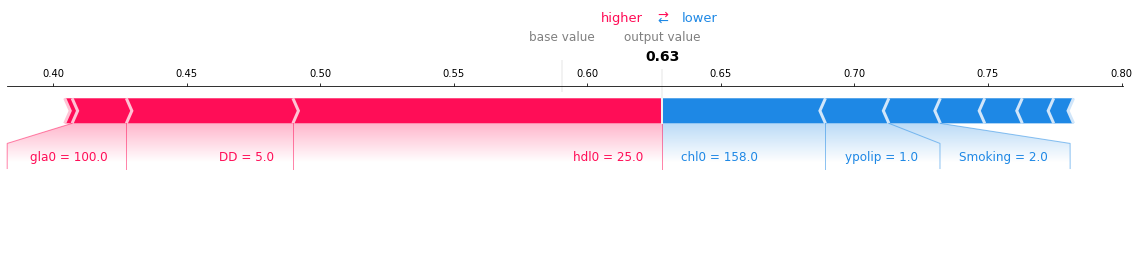

prediction YES
0.5240888201716272
0.6281033710867249
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
auc_valid 0.782608695652174 0.913043 7
103 50
auc_valid 0.9782608695652174 1.0 26
103 50
auc_valid 0.9673913043478262 1.0 20
103 50
auc_valid 0.9565217391304348 1.0 35
103 50
auc_valid 0.5 0.543478 14
103 50
auc_valid 0.7173913043478262 0.717391 1
[0.15964523281596452]
[0.15964523281596452, 0.19955654101995565]
[0.15964523281596452, 0.19955654101995565, 0.19733924611973394]
[0.15964523281596452, 0.19955654101995565, 0.19733924611973394, 0.1951219512195122]
[0.15964523281596452, 0.19955654101995565, 0.19733924611973394, 0.1951219512195122, 0.10199556541019955]
[0.15964523281596452, 0.19955654101995565, 0.19733924611973394, 0.1951219512195122, 0.10199556541019955, 0.14634146341463417]


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f0': 17.413765043636367, 'f4': 29.00604096, 'f9': 22.52938560090909, 'f6': 18.53250173045455, 'f10': 19.464794859999998, 'f1': 17.110157280714283, 'f2': 18.691932789166668, 'f8': 15.324478778000003, 'f3': 15.836017125000001, 'f5': 10.2803222925, 'f7': 11.878131383333335}
{'f0': 17.413765043636367, 'f4': 29.00604096, 'f9': 22.52938560090909, 'f6': 18.53250173045455, 'f10': 19.464794859999998, 'f1': 17.110157280714283, 'f2': 18.691932789166668, 'f8': 15.324478778000003, 'f3': 15.836017125000001, 'f5': 10.2803222925, 'f7': 11.878131383333335}
========== [0.15964523281596452, 0.19955654101995565, 0.19733924611973394, 0.1951219512195122, 0.10199556541019955, 0.14634146341463417] =============
{'f7': 19.813787689999998, 'f5': 16.36966116, 'f2': 18.5495879, 'f3': 29.482014966666664, 'f9': 19.23579446222222, 'f8': 18.560495090869562, 'f10': 17.096394540555554, 'f1': 16.142308233636367, 'f4': 29.041371666666667, 'f0': 17.338122632727273, 'f6': 16.55061638352941}
{'f7': 19.813787689999998, 'f5

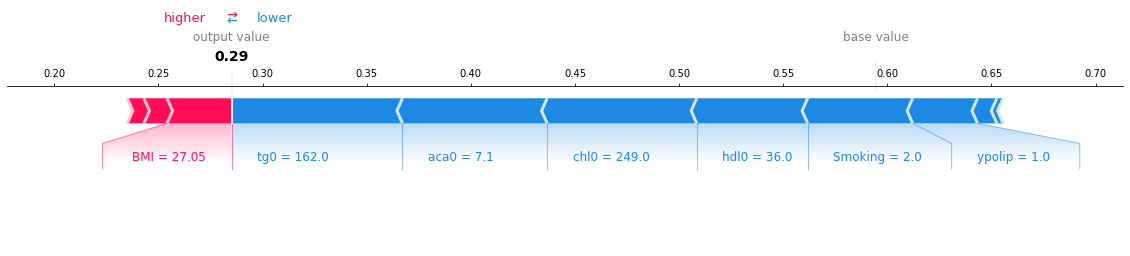

prediction NO
-0.9193002230047915
0.2851005001389138
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
auc_valid 0.891304347826087 0.945652 42
103 50
auc_valid 0.9239130434782609 1.0 10
103 50
auc_valid 0.9239130434782609 1.0 19
103 50
auc_valid 0.9673913043478262 1.0 34
103 50
auc_valid 0.8804347826086957 0.978261 45
103 50
auc_valid 0.75 0.733696 22
[0.16700610997963342]
[0.16700610997963342, 0.1731160896130346]
[0.16700610997963342, 0.1731160896130346, 0.1731160896130346]
[0.16700610997963342, 0.1731160896130346, 0.1731160896130346, 0.18126272912423624]
[0.16700610997963342, 0.1731160896130346, 0.1731160896130346, 0.18126272912423624, 0.16496945010183298]
[0.16700610997963342, 0.1731160896130346, 0.1731160896130346, 0.18126272912423624, 0.16496945010183298, 0.1405295315682281]
{'f2': 19.84690447157895, 'f9': 19.202094629285714, 'f6': 19.50492457764706, 'f1': 21.649073769166666, 'f0': 17.178887513333333, 'f4': 30.7838637, 'f10

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f7': 28.740509975, 'f5': 17.86960982, 'f2': 17.389381862666667, 'f1': 21.20250162416667, 'f6': 16.796965513125, 'f0': 18.115801597647057, 'f8': 17.372858643750003, 'f9': 17.39742823368421, 'f10': 20.508834189999998, 'f3': 14.63445545, 'f4': 25.668602}
{'f7': 28.740509975, 'f5': 17.86960982, 'f2': 17.389381862666667, 'f1': 21.20250162416667, 'f6': 16.796965513125, 'f0': 18.115801597647057, 'f8': 17.372858643750003, 'f9': 17.39742823368421, 'f10': 20.508834189999998, 'f3': 14.63445545, 'f4': 25.668602}
========== [0.16700610997963342, 0.1731160896130346, 0.1731160896130346, 0.18126272912423624, 0.16496945010183298, 0.1405295315682281] =============
{'f2': 20.386813706, 'f7': 21.826778955555557, 'f3': 19.86151816857143, 'f6': 20.30353274538462, 'f9': 19.039430506249996, 'f10': 20.135483345555553, 'f8': 20.035324319999997, 'f1': 17.444354777499996, 'f5': 17.0004533975, 'f4': 28.05258275, 'f0': 13.721955428571428}
{'f2': 20.386813706, 'f7': 21.826778955555557, 'f3': 19.86151816857143, 'f6

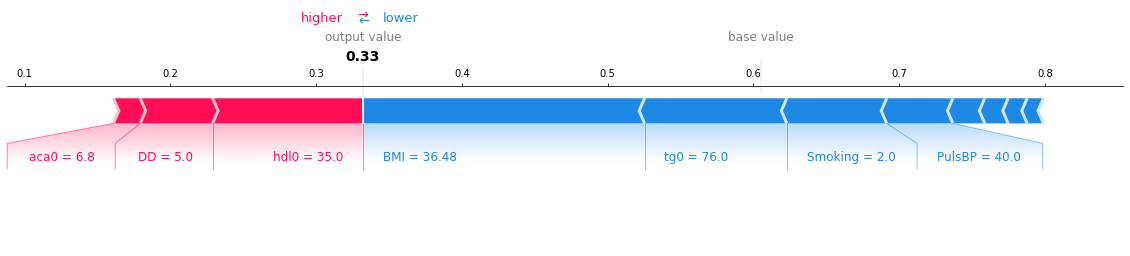

prediction NO
-0.698765647569159
0.3320859564480549
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
auc_valid 0.891304347826087 0.951087 74
103 50
auc_valid 0.9565217391304348 1.0 23
103 50
auc_valid 0.9456521739130435 1.0 24
103 50
auc_valid 0.9130434782608696 1.0 14
103 50
auc_valid 0.9021739130434783 0.978261 53
103 50
auc_valid 0.75 0.847826 58
[0.16632860040567954]
[0.16632860040567954, 0.17849898580121704]
[0.16632860040567954, 0.17849898580121704, 0.1764705882352941]
[0.16632860040567954, 0.17849898580121704, 0.1764705882352941, 0.17038539553752535]
[0.16632860040567954, 0.17849898580121704, 0.1764705882352941, 0.17038539553752535, 0.16835699797160245]
[0.16632860040567954, 0.17849898580121704, 0.1764705882352941, 0.17038539553752535, 0.16835699797160245, 0.13995943204868155]
{'f2': 20.27858347058824, 'f9': 19.938812386, 'f6': 19.53164029619048, 'f1': 18.841556669999996, 'f10': 18.847649822857143, 'f8': 17.6220854676470

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f7': 19.522994048333334, 'f5': 18.2681353, 'f2': 19.016891822352942, 'f8': 19.46092135307692, 'f10': 20.022633859999996, 'f9': 18.06323041894737, 'f0': 12.938128613, 'f4': 27.0081024, 'f1': 16.266707491428573, 'f3': 22.7141528, 'f6': 20.741439399999997}
{'f7': 19.522994048333334, 'f5': 18.2681353, 'f2': 19.016891822352942, 'f8': 19.46092135307692, 'f10': 20.022633859999996, 'f9': 18.06323041894737, 'f0': 12.938128613, 'f4': 27.0081024, 'f1': 16.266707491428573, 'f3': 22.7141528, 'f6': 20.741439399999997}
========== [0.16632860040567954, 0.17849898580121704, 0.1764705882352941, 0.17038539553752535, 0.16835699797160245, 0.13995943204868155] =============
{'f5': 18.998769284999998, 'f7': 17.977516405000003, 'f1': 19.564457788749998, 'f8': 15.81728573578947, 'f6': 20.551227376666663, 'f10': 16.52360068769231, 'f2': 19.578157557142855, 'f3': 15.228481993333332, 'f9': 18.268496169444443, 'f0': 17.324871313684213, 'f4': 34.3605423}
{'f5': 18.998769284999998, 'f7': 17.977516405000003, 'f1': 

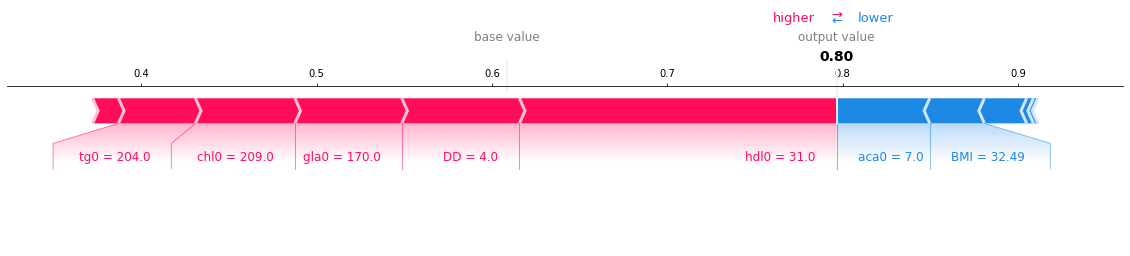

prediction YES
1.365259087774865
0.7966131078902501
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
auc_valid 0.9239130434782609 0.967391 36
103 50
auc_valid 0.9782608695652174 1.0 30
103 50
auc_valid 0.9891304347826088 1.0 44
103 50
auc_valid 0.9673913043478262 1.0 41
103 50
auc_valid 0.8804347826086957 0.945652 66
103 50
auc_valid 0.8043478260869565 0.913043 83
[0.16666666666666669]
[0.16666666666666669, 0.17647058823529413]
[0.16666666666666669, 0.17647058823529413, 0.17843137254901964]
[0.16666666666666669, 0.17647058823529413, 0.17843137254901964, 0.17450980392156867]
[0.16666666666666669, 0.17647058823529413, 0.17843137254901964, 0.17450980392156867, 0.15882352941176472]
[0.16666666666666669, 0.17647058823529413, 0.17843137254901964, 0.17450980392156867, 0.15882352941176472, 0.1450980392156863]
{'f5': 25.845790533333332, 'f2': 20.037574530624997, 'f9': 19.61425416666667, 'f6': 17.068859771153846, 'f1': 17.86398658375, 'f

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f7': 20.920343722222224, 'f5': 19.99109395444444, 'f2': 18.21226743384615, 'f8': 19.20460508565217, 'f10': 22.641879158333335, 'f9': 17.39501482, 'f0': 15.470484106666666, 'f4': 27.505536999999997, 'f1': 15.787158866999999, 'f3': 18.6986205, 'f6': 16.50041277888889}
{'f7': 20.920343722222224, 'f5': 19.99109395444444, 'f2': 18.21226743384615, 'f8': 19.20460508565217, 'f10': 22.641879158333335, 'f9': 17.39501482, 'f0': 15.470484106666666, 'f4': 27.505536999999997, 'f1': 15.787158866999999, 'f3': 18.6986205, 'f6': 16.50041277888889}
========== [0.16666666666666669, 0.17647058823529413, 0.17843137254901964, 0.17450980392156867, 0.15882352941176472, 0.1450980392156863] =============
{'f5': 16.757227665, 'f7': 15.16596331142857, 'f1': 16.43650723111111, 'f6': 18.865179733529416, 'f10': 20.17502460466667, 'f2': 19.274204584666663, 'f9': 16.857619602666666, 'f0': 16.031553961, 'f8': 16.619000498125, 'f4': 31.0387602, 'f3': 13.722330099999999}
{'f5': 16.757227665, 'f7': 15.16596331142857, 'f1

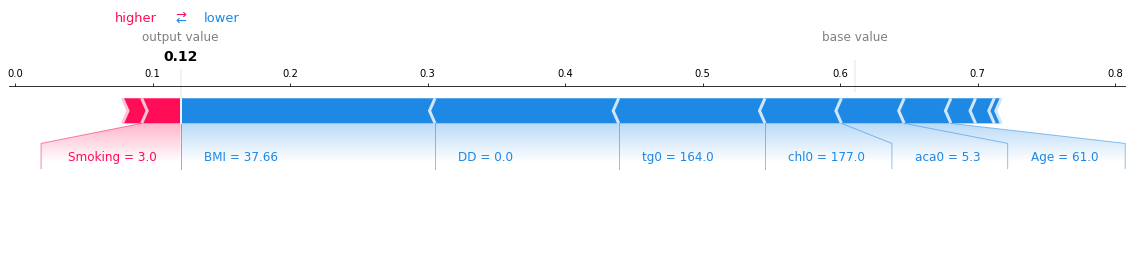

prediction NO
-1.9888871220981374
0.12037464931722887
11
56
Size of NoCvd cases in train set: 422
Size of Cvd cases in train set  : 32
validation_total 50
103 50
auc_valid 0.9673913043478262 1.0 28
103 50
auc_valid 0.9456521739130435 1.0 28
102 50
auc_valid 0.891304347826087 0.978261 53
102 50
auc_valid 0.8152173913043479 0.907609 76
102 50
auc_valid 0.8804347826086957 0.967391 72
102 50
auc_valid 0.7391304347826086 0.86413 17
[0.18464730290456435]
[0.18464730290456435, 0.18049792531120332]
[0.18464730290456435, 0.18049792531120332, 0.17012448132780086]
[0.18464730290456435, 0.18049792531120332, 0.17012448132780086, 0.15560165975103737]
[0.18464730290456435, 0.18049792531120332, 0.17012448132780086, 0.15560165975103737, 0.16804979253112035]
[0.18464730290456435, 0.18049792531120332, 0.17012448132780086, 0.15560165975103737, 0.16804979253112035, 0.14107883817427386]
{'f0': 17.663323220000002, 'f4': 32.073857, 'f2': 18.572735742857144, 'f8': 19.032838174090912, 'f10': 21.335220904, 'f1':

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f0': 18.22146542333333, 'f2': 18.390571697826083, 'f8': 18.982388179333334, 'f10': 19.817892923076922, 'f3': 18.282712783333334, 'f7': 14.930387854166666, 'f4': 21.609018350000003, 'f5': 28.92733, 'f6': 17.0276613068, 'f9': 17.603500553333333, 'f1': 16.88005092777778}
{'f0': 18.22146542333333, 'f2': 18.390571697826083, 'f8': 18.982388179333334, 'f10': 19.817892923076922, 'f3': 18.282712783333334, 'f7': 14.930387854166666, 'f4': 21.609018350000003, 'f5': 28.92733, 'f6': 17.0276613068, 'f9': 17.603500553333333, 'f1': 16.88005092777778}
========== [0.18464730290456435, 0.18049792531120332, 0.17012448132780086, 0.15560165975103737, 0.16804979253112035, 0.14107883817427386] =============
{'f2': 19.598188942142855, 'f5': 21.29060406, 'f9': 16.130261210555556, 'f8': 19.369544761578947, 'f6': 18.47020419909091, 'f7': 17.678514865999997, 'f10': 19.100633722999998, 'f1': 16.721108856249998, 'f3': 16.525045134285715, 'f0': 15.7596244875, 'f4': 16.0657501}
{'f2': 19.598188942142855, 'f5': 21.290

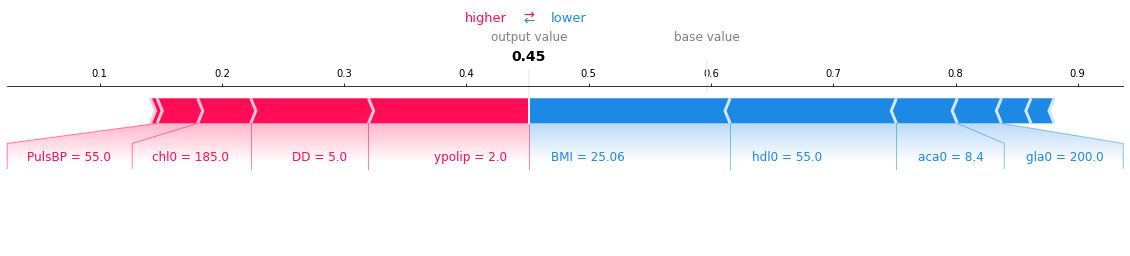

prediction NO
-0.19648637304167527
0.45103583500111805
11
56
----------------------------------------------------------------
[0.5, 2, 1000, 3, 0.5, 0.5, 1, 3, 0.75, 0, 1.0]
accuracy     0.6696428571428571
specificity  0.6649321266968325
sensitivity  0.735
auc          0.6999660633484163
brier_score  0.22356667657723736
weights      [0.2, 0.05, 0.33, 0.13, 0.15, 0.14]
----------------------------------------------------------------


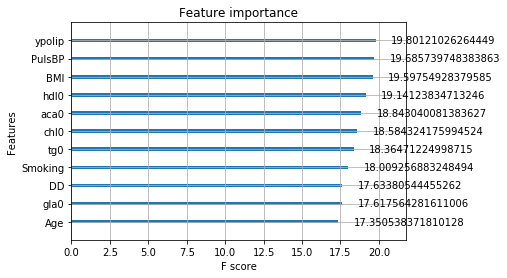

In [176]:

weights = [0.2, 0.05, 0.33, 0.13, 0.15, 0.14]

max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params,weights)

# parameters : [0.5, 2, 1000, 3, 0.5, 0.5, 1, 3, 0.75, 0, 1.0]
# accuracy : 0.6928571428571428
# spes     : 0.6860859728506787
# sens     : 0.785
# auc      : 0.7355429864253394
# weights  : [0.2, 0.1, 0.35, 0.1, 0.15, 0.1]

Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
103 50
103 50
103 50
103 50
103 50
{'f5': 7, 'f7': 8, 'f4': 4, 'f2': 19, 'f9': 19, 'f10': 11, 'f3': 5, 'f8': 8, 'f6': 8, 'f0': 10, 'f1': 10}
{'f5': 7, 'f7': 8, 'f4': 4, 'f2': 19, 'f9': 19, 'f10': 11, 'f3': 5, 'f8': 8, 'f6': 8, 'f0': 10, 'f1': 10}


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f7': 8, 'f4': 7, 'f3': 14, 'f8': 19, 'f1': 12, 'f10': 15, 'f6': 12, 'f0': 17, 'f2': 14, 'f9': 27, 'f5': 7}
{'f7': 8, 'f4': 7, 'f3': 14, 'f8': 19, 'f1': 12, 'f10': 15, 'f6': 12, 'f0': 17, 'f2': 14, 'f9': 27, 'f5': 7}
{'f2': 18, 'f5': 9, 'f3': 10, 'f6': 14, 'f9': 23, 'f0': 11, 'f4': 4, 'f8': 18, 'f10': 7, 'f7': 12, 'f1': 12}
{'f2': 18, 'f5': 9, 'f3': 10, 'f6': 14, 'f9': 23, 'f0': 11, 'f4': 4, 'f8': 18, 'f10': 7, 'f7': 12, 'f1': 12}
{'f2': 20, 'f5': 12, 'f3': 7, 'f9': 14, 'f8': 14, 'f0': 12, 'f10': 15, 'f6': 12, 'f7': 4, 'f1': 6, 'f4': 2}
{'f2': 20, 'f5': 12, 'f3': 7, 'f9': 14, 'f8': 14, 'f0': 12, 'f10': 15, 'f6': 12, 'f7': 4, 'f1': 6, 'f4': 2}
{'f2': 19, 'f9': 19, 'f8': 26, 'f3': 9, 'f0': 9, 'f10': 15, 'f6': 14, 'f5': 7, 'f1': 11, 'f4': 4, 'f7': 5}
{'f2': 19, 'f9': 19, 'f8': 26, 'f3': 9, 'f0': 9, 'f10': 15, 'f6': 14, 'f5': 7, 'f1': 11, 'f4': 4, 'f7': 5}
{'f2': 13, 'f5': 9, 'f3': 8, 'f1': 10, 'f9': 18, 'f10': 22, 'f8': 19, 'f7': 11, 'f6': 12, 'f0': 14, 'f4': 3}
{'f2': 13, 'f5': 9, 'f3':

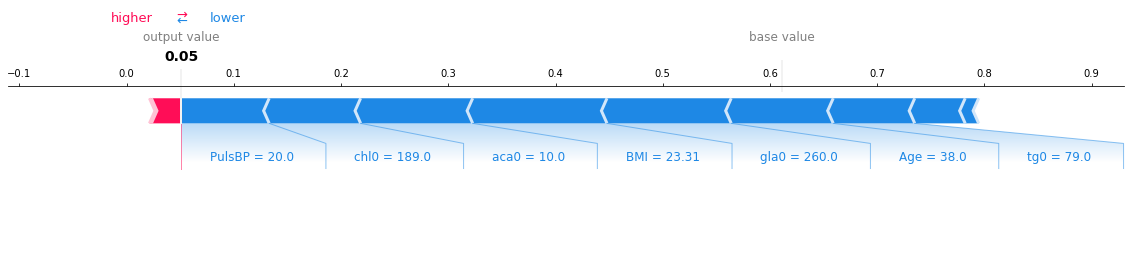

prediction NO
-2.923182404041291
0.05101939996311265
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
103 50
103 50
103 50
103 50
103 50
{'f5': 3, 'f7': 8, 'f2': 16, 'f1': 10, 'f6': 16, 'f10': 12, 'f8': 16, 'f9': 20, 'f4': 3, 'f0': 12, 'f3': 1}
{'f5': 3, 'f7': 8, 'f2': 16, 'f1': 10, 'f6': 16, 'f10': 12, 'f8': 16, 'f9': 20, 'f4': 3, 'f0': 12, 'f3': 1}


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f7': 10, 'f5': 5, 'f3': 8, 'f8': 14, 'f1': 10, 'f10': 15, 'f0': 12, 'f4': 7, 'f2': 9, 'f6': 9, 'f9': 13}
{'f7': 10, 'f5': 5, 'f3': 8, 'f8': 14, 'f1': 10, 'f10': 15, 'f0': 12, 'f4': 7, 'f2': 9, 'f6': 9, 'f9': 13}
{'f2': 21, 'f5': 8, 'f8': 22, 'f3': 5, 'f6': 17, 'f0': 10, 'f10': 13, 'f1': 19, 'f9': 13, 'f7': 13, 'f4': 3}
{'f2': 21, 'f5': 8, 'f8': 22, 'f3': 5, 'f6': 17, 'f0': 10, 'f10': 13, 'f1': 19, 'f9': 13, 'f7': 13, 'f4': 3}
{'f2': 22, 'f5': 10, 'f3': 4, 'f9': 16, 'f8': 17, 'f0': 21, 'f6': 10, 'f7': 8, 'f1': 12, 'f10': 13, 'f4': 1}
{'f2': 22, 'f5': 10, 'f3': 4, 'f9': 16, 'f8': 17, 'f0': 21, 'f6': 10, 'f7': 8, 'f1': 12, 'f10': 13, 'f4': 1}
{'f2': 16, 'f9': 16, 'f6': 12, 'f10': 28, 'f1': 14, 'f3': 7, 'f0': 12, 'f5': 7, 'f7': 9, 'f8': 17, 'f4': 5}
{'f2': 16, 'f9': 16, 'f6': 12, 'f10': 28, 'f1': 14, 'f3': 7, 'f0': 12, 'f5': 7, 'f7': 9, 'f8': 17, 'f4': 5}
{'f2': 11, 'f5': 6, 'f3': 6, 'f9': 19, 'f10': 20, 'f1': 8, 'f0': 13, 'f8': 16, 'f6': 6, 'f7': 10}
{'f2': 11, 'f5': 6, 'f3': 6, 'f9': 1

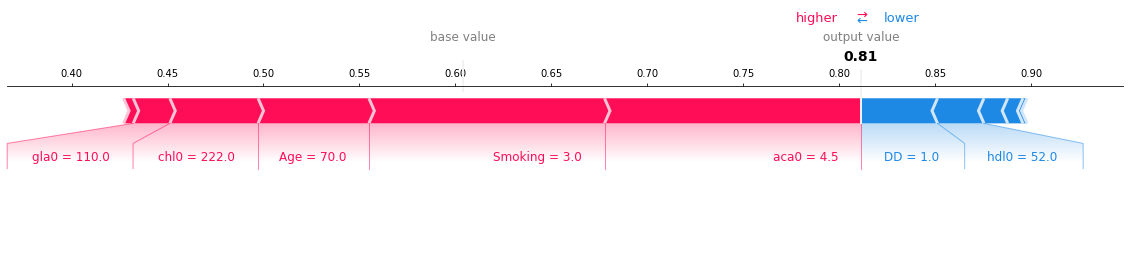

prediction YES
1.4586848962306975
0.811331450681675
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
103 50
103 50
103 50
103 50
103 50
{'f5': 7, 'f4': 5, 'f1': 9, 'f8': 16, 'f10': 15, 'f2': 10, 'f6': 22, 'f0': 13, 'f7': 8, 'f9': 13, 'f3': 3}
{'f5': 7, 'f4': 5, 'f1': 9, 'f8': 16, 'f10': 15, 'f2': 10, 'f6': 22, 'f0': 13, 'f7': 8, 'f9': 13, 'f3': 3}
{'f7': 11, 'f5': 6, 'f2': 14, 'f1': 7, 'f8': 27, 'f10': 15, 'f0': 5, 'f4': 6, 'f9': 14, 'f6': 5, 'f3': 3}
{'f7': 11, 'f5': 6, 'f2': 14, 'f1': 7, 'f8': 27, 'f10': 15, 'f0': 5, 'f4': 6, 'f9': 14, 'f6': 5, 'f3': 3}


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f2': 17, 'f5': 7, 'f8': 9, 'f10': 10, 'f1': 11, 'f6': 20, 'f7': 12, 'f3': 5, 'f0': 11, 'f9': 12, 'f4': 3}
{'f2': 17, 'f5': 7, 'f8': 9, 'f10': 10, 'f1': 11, 'f6': 20, 'f7': 12, 'f3': 5, 'f0': 11, 'f9': 12, 'f4': 3}
{'f0': 13, 'f7': 11, 'f2': 23, 'f8': 17, 'f1': 14, 'f9': 11, 'f5': 7, 'f6': 10, 'f10': 13, 'f4': 1, 'f3': 3}
{'f0': 13, 'f7': 11, 'f2': 23, 'f8': 17, 'f1': 14, 'f9': 11, 'f5': 7, 'f6': 10, 'f10': 13, 'f4': 1, 'f3': 3}
{'f2': 18, 'f7': 8, 'f1': 14, 'f6': 16, 'f10': 24, 'f3': 5, 'f9': 19, 'f0': 11, 'f8': 21, 'f4': 4, 'f5': 4}
{'f2': 18, 'f7': 8, 'f1': 14, 'f6': 16, 'f10': 24, 'f3': 5, 'f9': 19, 'f0': 11, 'f8': 21, 'f4': 4, 'f5': 4}
{'f2': 15, 'f5': 5, 'f3': 4, 'f8': 13, 'f6': 18, 'f10': 18, 'f1': 9, 'f9': 9, 'f0': 10, 'f7': 8, 'f4': 1}
{'f2': 15, 'f5': 5, 'f3': 4, 'f8': 13, 'f6': 18, 'f10': 18, 'f1': 9, 'f9': 9, 'f0': 10, 'f7': 8, 'f4': 1}


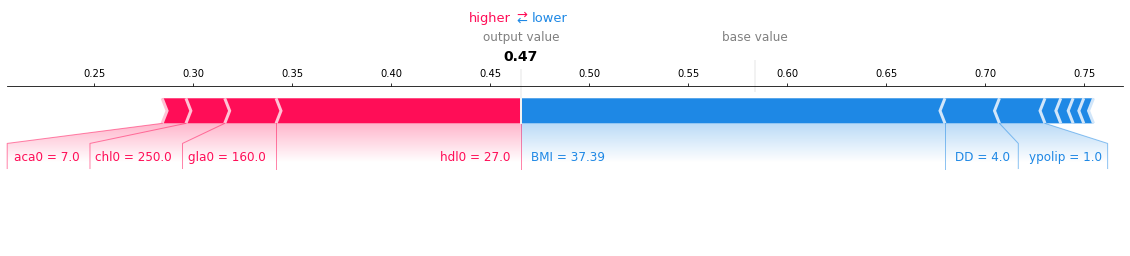

prediction NO
-0.13814584955573084
0.4655183582731507
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
103 50
103 50
103 50
103 50
103 50


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f5': 7, 'f4': 4, 'f9': 16, 'f6': 22, 'f10': 22, 'f1': 10, 'f2': 20, 'f7': 15, 'f8': 18, 'f0': 11}
{'f5': 7, 'f4': 4, 'f9': 16, 'f6': 22, 'f10': 22, 'f1': 10, 'f2': 20, 'f7': 15, 'f8': 18, 'f0': 11, 'f3': 0}
{'f2': 13, 'f7': 21, 'f8': 25, 'f10': 17, 'f3': 3, 'f9': 12, 'f5': 5, 'f4': 2, 'f6': 7, 'f1': 11, 'f0': 7}
{'f2': 13, 'f7': 21, 'f8': 25, 'f10': 17, 'f3': 3, 'f9': 12, 'f5': 5, 'f4': 2, 'f6': 7, 'f1': 11, 'f0': 7}
{'f2': 24, 'f5': 7, 'f9': 17, 'f3': 5, 'f6': 18, 'f4': 2, 'f7': 11, 'f8': 15, 'f10': 8, 'f1': 14, 'f0': 9}
{'f2': 24, 'f5': 7, 'f9': 17, 'f3': 5, 'f6': 18, 'f4': 2, 'f7': 11, 'f8': 15, 'f10': 8, 'f1': 14, 'f0': 9}
{'f2': 24, 'f5': 12, 'f6': 20, 'f0': 15, 'f9': 16, 'f7': 9, 'f10': 12, 'f3': 4, 'f8': 20, 'f1': 12, 'f4': 1}
{'f2': 24, 'f5': 12, 'f6': 20, 'f0': 15, 'f9': 16, 'f7': 9, 'f10': 12, 'f3': 4, 'f8': 20, 'f1': 12, 'f4': 1}
{'f2': 14, 'f5': 8, 'f9': 18, 'f6': 15, 'f10': 20, 'f1': 12, 'f3': 6, 'f8': 24, 'f0': 9, 'f7': 5, 'f4': 1}
{'f2': 14, 'f5': 8, 'f9': 18, 'f6': 15

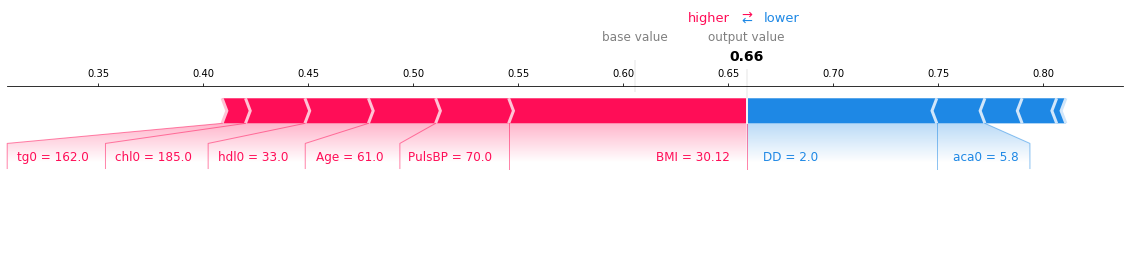

prediction YES
0.6577897852659225
0.6587637197449654
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
103 50
103 50
103 50
103 50
103 50
{'f0': 13, 'f4': 4, 'f9': 11, 'f6': 19, 'f1': 9, 'f10': 23, 'f8': 17, 'f3': 3, 'f7': 6, 'f2': 12, 'f5': 3}
{'f0': 13, 'f4': 4, 'f9': 11, 'f6': 19, 'f1': 9, 'f10': 23, 'f8': 17, 'f3': 3, 'f7': 6, 'f2': 12, 'f5': 3}
{'f2': 12, 'f7': 12, 'f3': 5, 'f8': 19, 'f10': 8, 'f9': 17, 'f0': 8, 'f5': 8, 'f6': 13, 'f4': 1, 'f1': 8}
{'f2': 12, 'f7': 12, 'f3': 5, 'f8': 19, 'f10': 8, 'f9': 17, 'f0': 8, 'f5': 8, 'f6': 13, 'f4': 1, 'f1': 8}
{'f2': 12, 'f5': 12, 'f1': 15, 'f6': 15, 'f10': 11, 'f3': 4, 'f4': 3, 'f8': 14, 'f7': 9, 'f0': 15, 'f9': 17}
{'f2': 12, 'f5': 12, 'f1': 15, 'f6': 15, 'f10': 11, 'f3': 4, 'f4': 3, 'f8': 14, 'f7': 9, 'f0': 15, 'f9': 17}
{'f2': 15, 'f5': 15, 'f3': 7, 'f9': 10, 'f8': 17, 'f0': 10, 'f10': 16, 'f7': 11, 'f6': 12, 'f4': 2, 'f1': 4}
{'f2': 15, 'f5': 15, 'f3': 7, 'f9': 10, 'f8': 17, '

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


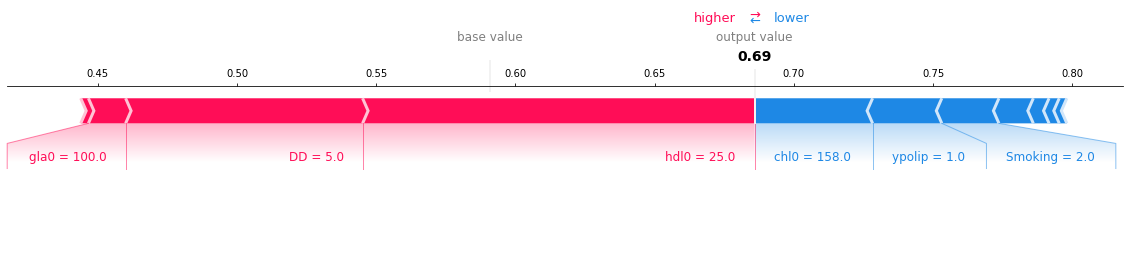

prediction YES
0.781019975244999
0.6858999003119756
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
103 50
103 50
103 50
103 50
103 50
{'f0': 11, 'f4': 5, 'f9': 11, 'f6': 22, 'f10': 15, 'f1': 14, 'f2': 12, 'f8': 15, 'f3': 4, 'f5': 4, 'f7': 3}
{'f0': 11, 'f4': 5, 'f9': 11, 'f6': 22, 'f10': 15, 'f1': 14, 'f2': 12, 'f8': 15, 'f3': 4, 'f5': 4, 'f7': 3}
{'f7': 10, 'f5': 5, 'f2': 13, 'f3': 3, 'f9': 18, 'f8': 23, 'f10': 18, 'f1': 11, 'f4': 3, 'f0': 11, 'f6': 17}
{'f7': 10, 'f5': 5, 'f2': 13, 'f3': 3, 'f9': 18, 'f8': 23, 'f10': 18, 'f1': 11, 'f4': 3, 'f0': 11, 'f6': 17}
{'f7': 13, 'f5': 8, 'f2': 13, 'f9': 14, 'f6': 12, 'f10': 11, 'f1': 14, 'f3': 7, 'f0': 16, 'f4': 3, 'f8': 12}
{'f7': 13, 'f5': 8, 'f2': 13, 'f9': 14, 'f6': 12, 'f10': 11, 'f1': 14, 'f3': 7, 'f0': 16, 'f4': 3, 'f8': 12}
{'f0': 18, 'f7': 15, 'f3': 5, 'f8': 22, 'f9': 11, 'f10': 16, 'f1': 17, 'f6': 16, 'f5': 7, 'f2': 12, 'f4': 1}
{'f0': 18, 'f7': 15, 'f3': 5, 'f8': 22, 'f9'

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f2': 15, 'f5': 5, 'f3': 8, 'f9': 17, 'f10': 11, 'f7': 9, 'f8': 14, 'f0': 13, 'f4': 2, 'f6': 8, 'f1': 9}
{'f2': 15, 'f5': 5, 'f3': 8, 'f9': 17, 'f10': 11, 'f7': 9, 'f8': 14, 'f0': 13, 'f4': 2, 'f6': 8, 'f1': 9}


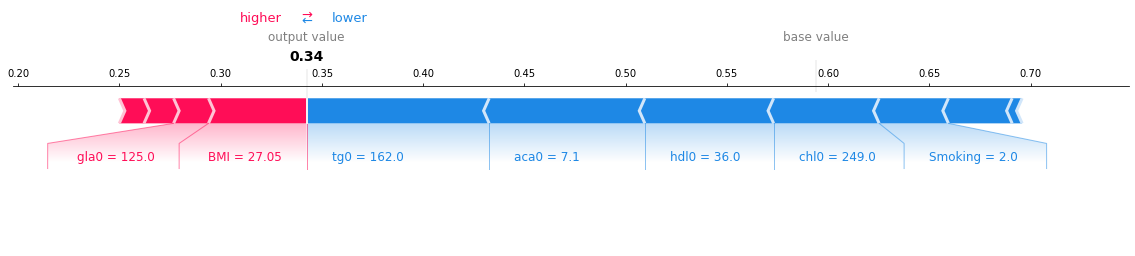

prediction NO
-0.6524597632139921
0.342435449580547
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
103 50
103 50
103 50
103 50
103 50
{'f2': 19, 'f9': 14, 'f6': 17, 'f1': 12, 'f0': 12, 'f4': 3, 'f10': 19, 'f7': 12, 'f8': 11, 'f5': 5, 'f3': 5}
{'f2': 19, 'f9': 14, 'f6': 17, 'f1': 12, 'f0': 12, 'f4': 3, 'f10': 19, 'f7': 12, 'f8': 11, 'f5': 5, 'f3': 5}


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f7': 11, 'f5': 1, 'f2': 15, 'f9': 18, 'f6': 10, 'f1': 17, 'f10': 8, 'f4': 3, 'f8': 19, 'f3': 3, 'f0': 11}
{'f7': 11, 'f5': 1, 'f2': 15, 'f9': 18, 'f6': 10, 'f1': 17, 'f10': 8, 'f4': 3, 'f8': 19, 'f3': 3, 'f0': 11}
{'f7': 4, 'f5': 8, 'f2': 15, 'f1': 12, 'f6': 16, 'f0': 17, 'f8': 16, 'f9': 19, 'f10': 10, 'f3': 4, 'f4': 2}
{'f7': 4, 'f5': 8, 'f2': 15, 'f1': 12, 'f6': 16, 'f0': 17, 'f8': 16, 'f9': 19, 'f10': 10, 'f3': 4, 'f4': 2}
{'f2': 15, 'f7': 9, 'f3': 7, 'f6': 13, 'f9': 16, 'f10': 18, 'f8': 15, 'f1': 16, 'f5': 12, 'f4': 2, 'f0': 7}
{'f2': 15, 'f7': 9, 'f3': 7, 'f6': 13, 'f9': 16, 'f10': 18, 'f8': 15, 'f1': 16, 'f5': 12, 'f4': 2, 'f0': 7}
{'f2': 18, 'f1': 15, 'f8': 13, 'f9': 26, 'f3': 8, 'f0': 7, 'f7': 10, 'f6': 17, 'f5': 7, 'f10': 10, 'f4': 1}
{'f2': 18, 'f1': 15, 'f8': 13, 'f9': 26, 'f3': 8, 'f0': 7, 'f7': 10, 'f6': 17, 'f5': 7, 'f10': 10, 'f4': 1}
{'f2': 12, 'f3': 8, 'f9': 17, 'f10': 21, 'f8': 11, 'f7': 17, 'f0': 9, 'f6': 12, 'f1': 9, 'f5': 6}
{'f2': 12, 'f3': 8, 'f9': 17, 'f10': 2

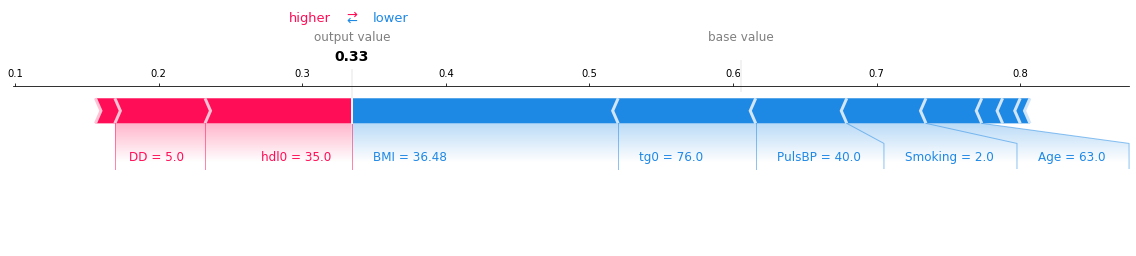

prediction NO
-0.6878887769579887
0.33450288977213605
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
103 50
103 50
103 50
103 50
103 50


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f2': 17, 'f9': 15, 'f6': 21, 'f1': 13, 'f10': 21, 'f8': 17, 'f4': 3, 'f5': 6, 'f7': 13, 'f0': 13, 'f3': 4}
{'f2': 17, 'f9': 15, 'f6': 21, 'f1': 13, 'f10': 21, 'f8': 17, 'f4': 3, 'f5': 6, 'f7': 13, 'f0': 13, 'f3': 4}
{'f7': 12, 'f5': 4, 'f2': 17, 'f8': 26, 'f10': 14, 'f9': 19, 'f0': 10, 'f4': 3, 'f1': 14, 'f3': 4, 'f6': 7}
{'f7': 12, 'f5': 4, 'f2': 17, 'f8': 26, 'f10': 14, 'f9': 19, 'f0': 10, 'f4': 3, 'f1': 14, 'f3': 4, 'f6': 7}
{'f5': 6, 'f7': 8, 'f1': 16, 'f8': 19, 'f6': 15, 'f10': 13, 'f2': 14, 'f3': 6, 'f9': 18, 'f0': 19, 'f4': 1}
{'f5': 6, 'f7': 8, 'f1': 16, 'f8': 19, 'f6': 15, 'f10': 13, 'f2': 14, 'f3': 6, 'f9': 18, 'f0': 19, 'f4': 1}
{'f2': 18, 'f7': 12, 'f3': 6, 'f8': 15, 'f9': 17, 'f10': 14, 'f1': 17, 'f5': 7, 'f6': 16, 'f0': 4, 'f4': 1}
{'f2': 18, 'f7': 12, 'f3': 6, 'f8': 15, 'f9': 17, 'f10': 14, 'f1': 17, 'f5': 7, 'f6': 16, 'f0': 4, 'f4': 1}
{'f2': 26, 'f5': 7, 'f9': 12, 'f6': 12, 'f8': 19, 'f1': 14, 'f10': 13, 'f3': 4, 'f0': 10, 'f7': 7, 'f4': 1}
{'f2': 26, 'f5': 7, 'f9': 

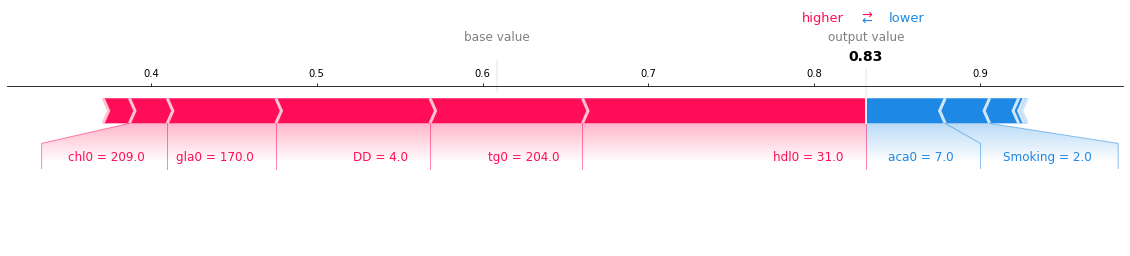

prediction YES
1.5945673033595085
0.8312577206694359
11
56
Size of NoCvd cases in train set: 421
Size of Cvd cases in train set  : 33
validation_total 50
104 50
103 50
103 50
103 50
103 50
103 50
{'f5': 3, 'f2': 16, 'f9': 12, 'f6': 26, 'f1': 16, 'f10': 20, 'f8': 19, 'f0': 13, 'f4': 2, 'f7': 7, 'f3': 2}
{'f5': 3, 'f2': 16, 'f9': 12, 'f6': 26, 'f1': 16, 'f10': 20, 'f8': 19, 'f0': 13, 'f4': 2, 'f7': 7, 'f3': 2}
{'f7': 9, 'f5': 9, 'f2': 13, 'f8': 23, 'f10': 12, 'f9': 19, 'f0': 6, 'f4': 2, 'f1': 10, 'f3': 3, 'f6': 18}
{'f7': 9, 'f5': 9, 'f2': 13, 'f8': 23, 'f10': 12, 'f9': 19, 'f0': 6, 'f4': 2, 'f1': 10, 'f3': 3, 'f6': 18}
{'f5': 6, 'f7': 7, 'f1': 18, 'f6': 17, 'f10': 15, 'f2': 15, 'f9': 15, 'f0': 20, 'f8': 16, 'f4': 2, 'f3': 3}
{'f5': 6, 'f7': 7, 'f1': 18, 'f6': 17, 'f10': 15, 'f2': 15, 'f9': 15, 'f0': 20, 'f8': 16, 'f4': 2, 'f3': 3}


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f5': 4, 'f2': 15, 'f8': 24, 'f10': 20, 'f1': 16, 'f6': 19, 'f0': 10, 'f9': 13, 'f3': 6, 'f7': 9, 'f4': 2}
{'f5': 4, 'f2': 15, 'f8': 24, 'f10': 20, 'f1': 16, 'f6': 19, 'f0': 10, 'f9': 13, 'f3': 6, 'f7': 9, 'f4': 2}
{'f2': 29, 'f5': 5, 'f9': 13, 'f6': 9, 'f8': 18, 'f0': 16, 'f10': 13, 'f1': 14, 'f7': 4, 'f3': 2}
{'f2': 29, 'f5': 5, 'f9': 13, 'f6': 9, 'f8': 18, 'f0': 16, 'f10': 13, 'f1': 14, 'f7': 4, 'f3': 2, 'f4': 0}
{'f2': 13, 'f7': 14, 'f1': 15, 'f6': 11, 'f8': 16, 'f10': 16, 'f3': 10, 'f0': 10, 'f5': 11, 'f9': 21, 'f4': 1}
{'f2': 13, 'f7': 14, 'f1': 15, 'f6': 11, 'f8': 16, 'f10': 16, 'f3': 10, 'f0': 10, 'f5': 11, 'f9': 21, 'f4': 1}


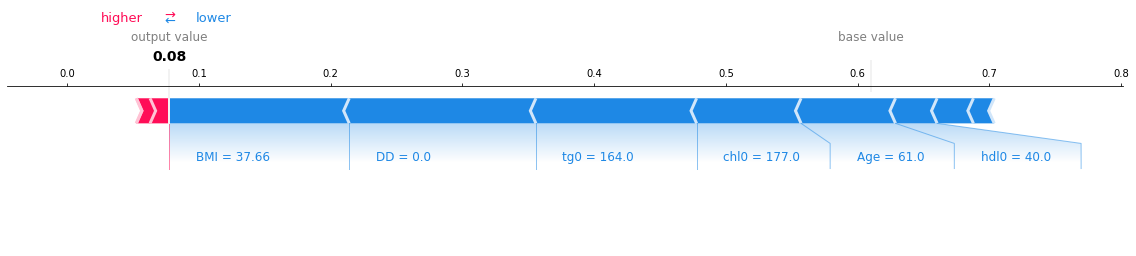

prediction NO
-2.4769172790646556
0.07749229050035296
11
56
Size of NoCvd cases in train set: 422
Size of Cvd cases in train set  : 32
validation_total 50
103 50
103 50
102 50
102 50
102 50
102 50
{'f0': 10, 'f4': 3, 'f2': 21, 'f8': 22, 'f10': 10, 'f1': 9, 'f9': 21, 'f7': 8, 'f5': 7, 'f6': 13, 'f3': 5}
{'f0': 10, 'f4': 3, 'f2': 21, 'f8': 22, 'f10': 10, 'f1': 9, 'f9': 21, 'f7': 8, 'f5': 7, 'f6': 13, 'f3': 5}
{'f5': 7, 'f7': 9, 'f2': 19, 'f1': 18, 'f8': 9, 'f10': 16, 'f9': 14, 'f4': 4, 'f6': 11, 'f0': 8, 'f3': 2}
{'f5': 7, 'f7': 9, 'f2': 19, 'f1': 18, 'f8': 9, 'f10': 16, 'f9': 14, 'f4': 4, 'f6': 11, 'f0': 8, 'f3': 2}
{'f0': 12, 'f2': 23, 'f8': 15, 'f10': 13, 'f3': 6, 'f7': 12, 'f4': 4, 'f5': 3, 'f6': 25, 'f9': 15, 'f1': 9}
{'f0': 12, 'f2': 23, 'f8': 15, 'f10': 13, 'f3': 6, 'f7': 12, 'f4': 4, 'f5': 3, 'f6': 25, 'f9': 15, 'f1': 9}


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


{'f2': 28, 'f5': 8, 'f9': 18, 'f8': 19, 'f6': 11, 'f7': 15, 'f10': 10, 'f1': 16, 'f3': 7, 'f0': 8, 'f4': 1}
{'f2': 28, 'f5': 8, 'f9': 18, 'f8': 19, 'f6': 11, 'f7': 15, 'f10': 10, 'f1': 16, 'f3': 7, 'f0': 8, 'f4': 1}
{'f0': 19, 'f2': 15, 'f9': 16, 'f6': 18, 'f1': 15, 'f8': 18, 'f7': 14, 'f3': 5, 'f5': 9, 'f10': 13, 'f4': 1}
{'f0': 19, 'f2': 15, 'f9': 16, 'f6': 18, 'f1': 15, 'f8': 18, 'f7': 14, 'f3': 5, 'f5': 9, 'f10': 13, 'f4': 1}
{'f2': 16, 'f7': 8, 'f9': 20, 'f8': 16, 'f10': 14, 'f3': 5, 'f0': 10, 'f5': 6, 'f6': 11, 'f1': 11, 'f4': 5}
{'f2': 16, 'f7': 8, 'f9': 20, 'f8': 16, 'f10': 14, 'f3': 5, 'f0': 10, 'f5': 6, 'f6': 11, 'f1': 11, 'f4': 5}


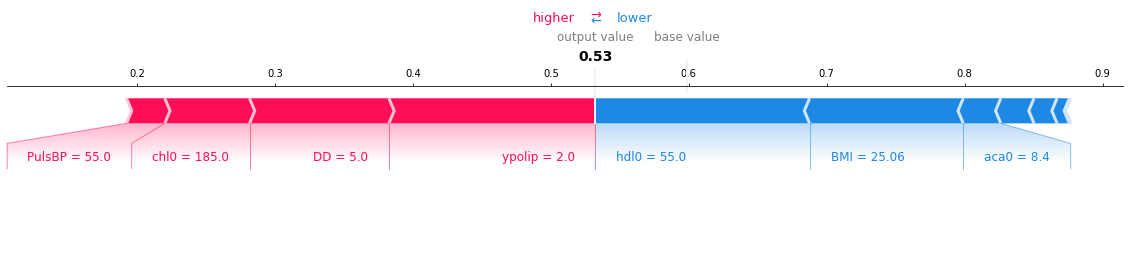

prediction YES
0.1295805084705353
0.5323498739275869
11
56


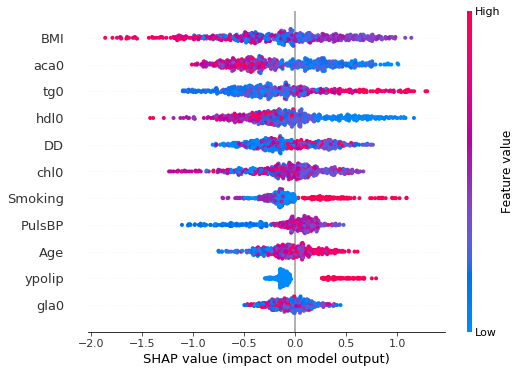

----------------------------------------------------------------
[0.5, 2, 1000, 3, 0.5, 0.5, 1, 3, 0.75, 0, 1.0]
accuracy     0.6875
specificity  0.6802790346907994
sensitivity  0.785
auc          0.7326395173453997
weights      [0.2, 0.05, 0.33, 0.13, 0.15, 0.14]
----------------------------------------------------------------


In [457]:

weights = [0.2, 0.05, 0.33, 0.13, 0.15, 0.14]

max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params,weights)